In [1]:
import numpy as np
import pandas as pd
import quantecon as qe
from ast import literal_eval
from sklearn.ensemble import RandomForestRegressor
import ternary
import random
import plotly.figure_factory as ff
import colorsys
from matplotlib import pyplot as plt
import math

In [2]:
def create_bayesian_table(name, experiment_per_generation):
    df = pd.read_csv('Data_Bayes/'+ str(name) + '.txt', sep='\t')
    elements = ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']
    x_old = df[elements].to_numpy()
    x_old = np.around(x_old, decimals = 3)
    
    ID = list(range(1, experiment_per_generation+1))*(math.ceil(len(df)/experiment_per_generation))
    ID = np.array(ID[0:len(df)])

    gen = []
    for i in range(math.ceil(len(df)/experiment_per_generation)):
        gen.append([i]*experiment_per_generation)
    gen = np.array(gen)
    gen = np.reshape(gen, -1)
    gen = gen[0:len(df)]
    
    data = {'ID' : ID, 'Elements': [elements], 'Generation': gen}
    datalog = pd.DataFrame(data=data, index = np.arange(len(df)))
    datalog = pd.concat([datalog, pd.DataFrame(([[i] for i in x_old]), columns = ['Position'])], axis = 1)
    datalog['Activity'] = df['COC_Opt']
    datalog.to_csv('Benchmarking/Datalog '+str(name)+'.txt', sep='\t', index=False, mode='w')
    return datalog

In [3]:
class grid:
    def __init__(self, data, grid_len, name):
        self.datalog = data
        self.datalog = self.datalog[['ID', 'Elements', 'Generation', 'Position', 'Activity']]
        self.grid_len = grid_len
        self.generation = self.datalog['Generation'].max()
        
        #Creating "Region" column
        self.determine_grid_points()
        self.determine_region()
        self.datalog['Region'] = self.region
    
        #Creating "Visited" column
        self.visited = []
        for i in range(len(self.datalog)):
            check = self.datalog.at[i, 'Region'] == self.datalog.loc[0:(i-1)]['Region']
            if np.count_nonzero(check) == 0:
                self.visited.append(False)
            else:
                self.visited.append(True)
        self.datalog['Visited'] = self.visited
        
        #Renaming index column
        self.datalog.index.name = 'Experiment'
        
        
        #Saving (delete later)
        self.datalog.to_csv('Benchmarking/Grid Datalog '+str(name)+'.txt', sep='\t', index=False, mode='w')

        
    
    def determine_grid_points(self):
        simplex_grid = qe.simplex_grid(len(self.datalog['Elements'][0]), self.grid_len)/self.grid_len

        #Translating Vector
        translation = 1/(self.grid_len*len(self.datalog['Elements'][0]))
        translating_vector = [-(len(self.datalog['Elements'][0])-1)*translation]
        for i in range(len(self.datalog['Elements'][0])-1):
            translating_vector.append(translation)
        translating_vector = np.array(translating_vector)                  
        
        #Making grid
        grid_points_1 = simplex_grid + translating_vector
        grid_points_2 = simplex_grid + 2*translating_vector
        self.grid_points = np.vstack((grid_points_1, grid_points_2))
        self.grid_points = np.around(self.grid_points, decimals = 4)
        self.grid_points = self.grid_points[self.grid_points[:, 0].argsort()]

        #Deleting grid points outside the space
        self.grid_points = np.delete(self.grid_points, np.where(self.grid_points<0)[0], axis = 0)
        self.grid_points = np.delete(self.grid_points, np.where(self.grid_points>1)[0], axis = 0)
        return
    
    def determine_region(self):
        #Determining region
        self.region = []
        for i in range(len(self.datalog)):
            distance = []
            for x in range(len(self.grid_points)):
                distance.append(np.sqrt(sum((self.datalog.at[i, 'Position']-self.grid_points[x])**2)))
            distance = np.array(distance)
            self.region.append(distance.argmin())
        self.region = np.array(self.region)
        return
      
    def count_occurences(self):
        #Count Occurrences of Each Grid
        self.grid_count = []
        for i in range(len(self.grid_points)):
            self.grid_count.append((self.datalog['Region'] == i).sum())
        self.grid_count = np.array(self.grid_count)
        return
    
    def create_grid_table(self):
        self.count_occurences()
        #Creating Exploration Table
        self.grid_table = pd.DataFrame(([[self.datalog['Elements'][0]] for i in self.grid_points]), columns = ['Elements'])
        self.grid_table = pd.concat([self.grid_table, pd.DataFrame(([[i] for i in self.grid_points]), columns = ['Point'])], axis = 1)
        self.grid_table['Region'] = np.arange(len(self.grid_points))
        self.grid_table['Count'] = self.grid_count
        for i in range(len(self.grid_table)):
            self.grid_table.at[i, 'First visit'] = self.datalog[self.datalog['Region'] == i].index.min()
        
        
        #Saving (delete later)
        self.grid_table.to_csv('Benchmarking/Grid Table '+str(name)+'.txt', sep='\t', index=False, mode='w')
        
        
        return self.grid_table
    
    def exploitation_value(self):
        self.exploitation_data = []
        for i in range(self.generation+1):
            max_observation = self.datalog[0:(i+1)*self.datalog['ID'].max()]
            self.exploitation_data.append(1-(len(np.unique(max_observation['Region'])))/len(max_observation))
        self.exploitation_data = np.array(self.exploitation_data)
        self.exploitation_data = np.around(self.exploitation_data, decimals = 3)
        return self.exploitation_data[-1]
    
    def exploration_value(self):
        self.exploration_data = []
        for i in range(self.generation+1):
            max_observation = self.datalog[0:(i+1)*self.datalog['ID'].max()]
            self.exploration_data.append(len(np.unique(max_observation['Region']))/len(self.grid_points))
        self.exploration_data = np.array(self.exploration_data)
        self.exploration_data = np.around(self.exploration_data, decimals = 3)
        return self.exploration_data[-1]
        
    def exploitation_bar_chart(self, min_number = 3):
        self.create_grid_table()
        #Creating table for bar chart
        self.exploitation_bar_chart_table = self.grid_table.loc[self.grid_table['Count'] >= min_number].reset_index(drop=True)
        self.exploitation_bar_chart_table['Region'] = self.exploitation_bar_chart_table['Region'].astype(str)
        self.exploitation_bar_chart_table['Point'] = self.exploitation_bar_chart_table['Point'].astype(str)
      
    
        #Saving (delete later)
        self.exploitation_bar_chart_table.to_csv('Benchmarking/Exploitation Bar Chart Table '+str(name)+'.txt', sep='\t', index=False, mode='w')
        
        
        """#Plotting
        #Figure Size
        fig, ax = plt.subplots(figsize =(10, 7))

        #Horizontal Bar Plot
        ax.barh(self.exploitation_bar_chart_table['Point'], self.exploitation_bar_chart_table['Count'],
                color ='blue')

        plt.xlabel('Count')
        plt.ylabel('Point ' + str(self.datalog['Elements'][0]))
        plt.title('Exploitation Bar Chart')
        plt.show()"""
        return
        
    def exploration_vs_generation(self):
        self.exploration_value()
        y = self.exploration_data
        x = np.arange(self.generation+1)
        
        
        #Saving(delete later)
        d = {'Generation': x, 'Exploration Value': y}
        self.exploration_vs_generation_table = pd.DataFrame(data=d)
        self.exploration_vs_generation_table.to_csv('Benchmarking/Exploration vs Generation Table '+str(name)+'.txt', sep='\t', index=False, mode='w')
        
        
        """#Plotting
        fig = plt.figure(figsize = (7, 5))

        plt.plot(x, y, marker = 'o', color = 'blue')
        plt.xticks(np.arange(0, self.generation+1, 1))
        plt.ylim(0, 1)
        plt.xlabel('Generation')
        plt.ylabel('Exploration')
        plt.show()"""
        return
    
    def exploitation_vs_generation(self):
        self.exploitation_value()
        y = self.exploitation_data
        x = np.arange(self.generation+1)

        
        #Saving(delete later)
        d = {'Generation': x, 'Exploitation Value': y}
        self.exploitation_vs_generation_table = pd.DataFrame(data=d)
        self.exploitation_vs_generation_table.to_csv('Benchmarking/Exploitation vs Generation Table '+str(name)+'.txt', sep='\t', index=False, mode='w')
        
        
        """#Plotting
        fig = plt.figure(figsize = (7, 5))

        plt.plot(x, y, marker = 'o', color = 'blue')
        plt.xticks(np.arange(0, self.generation+1, 1))
        plt.ylim(0, 1)
        plt.xlabel('Generation')
        plt.ylabel('Exploitation')
        plt.show()"""
        return

In [4]:
class find_generation:
    def __init__(self, data, name):
        self.datalog = data
        self.datalog = self.datalog[['ID', 'Elements', 'Generation', 'Position', 'Activity']]
        self.generation = self.datalog['Generation'].max()
    
    def g_best(self):
        return self.datalog.loc[np.argmin(self.datalog['Activity'])]
    
    def find_distance(self, target):
        self.distance = []
        for i in range(len(self.datalog)):
            self.distance.append(np.sqrt(sum((self.datalog.at[i, 'Position']-target)**2)))
        self.distance = np.array(self.distance)
        self.distance = np.around(self.distance, decimals = 3)
        return
    
    def first_to_reach_limit(self, target, limit):
        self.find_distance(target)
        #Find the first position to reach the limit
        if len(np.array(np.where(self.distance < limit))[0]) == 0:
            result = None
        else:
            result = self.datalog.loc[np.array(np.where(self.distance < limit)).min()]
        return result
    
    def distance_vs_generation(self, target, title):
        self.find_distance(target)
        #Creating Distance vs Generation Table
        self.distance_value = []
        for i in range(self.generation+1):
            self.distance_value.append(self.distance[0:((i+1)*self.generation)].min())
        self.distance_value_vs_generation_table = pd.DataFrame((np.arange(self.generation+1)), columns = ['Generation'])
        self.distance_value_vs_generation_table['Distance'] = self.distance_value
        
        
        #Saving(delete later)
        self.distance_value_vs_generation_table.to_csv('Benchmarking/Distance ' + 'to ' + str(title) + ' vs Generation Table '+ str(name) + '.txt', sep='\t', index=False, mode='w')
        
        
        """#Plotting
        plt.plot(self.distance_value_vs_generation_table['Generation'], self.distance_value_vs_generation_table['Distance'], marker = 'o', color = 'blue')
        plt.ylim(-0.05, 1)
        plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xlabel('Generation')
        plt.ylabel('Distance')
        plt.show()"""
        return
    
    
    
    def min_value_vs_generation(self):
        #Creating Minimum Value vs Generation Table
        self.min_value = []
        for i in range(self.generation+1):
            self.min_value.append(self.datalog.loc[self.datalog['Generation'] <= i]['Activity'].min())
        self.min_value_vs_generation_table = pd.DataFrame((np.arange(self.generation+1)), columns = ['Generation'])
        self.min_value_vs_generation_table['min_value'] = self.min_value
        
        
        #Saving(delete later)
        self.min_value_vs_generation_table.to_csv('Benchmarking/Minimum Value vs Generation Table '+str(name)+'.txt', sep='\t', index=False, mode='w')
        
        
        """#Plotting
        plt.plot(self.min_value_vs_generation_table['Generation'], self.min_value_vs_generation_table['min_value'], marker = 'o', color = 'blue')
        plt.ylim(-1.5, 0)
        plt.xlabel('Generation')
        plt.ylabel('Min Value')
        plt.show()"""
        return

In [5]:
bayes_2000_best = np.array([0.397, 0.243, 0.288, 0.037, 0.   , 0.   , 0.   , 0.035])

In [6]:
for i in range(20):
    name = 'Bayesian vs PSO ' + str(i)
    datalog = create_bayesian_table(name, experiment_per_generation = 1)
    
    #Grid
    bayesian_grid = grid(datalog, grid_len = 5, name = name)
    bayesian_grid.exploitation_bar_chart(5)
    bayesian_grid.exploitation_vs_generation()
    bayesian_grid.exploration_vs_generation()

    #Find required generation
    bayesian_find_generation = find_generation(datalog, name = name)
    bayesian_find_generation.distance_vs_generation(target = bayes_2000_best, title = 'Bayes Best Position')
    bayesian_find_generation.distance_vs_generation(target = bayesian_find_generation.g_best()['Position'], title = 'Best Position')
    bayesian_find_generation.min_value_vs_generation()

KeyboardInterrupt: 

In [7]:
class benchmark:
    def __init__ (self, datatype, title, max_generation, repetition, y_value):
        self.table = pd.DataFrame(list(range(0, (max_generation+1))), columns = ['Generation'])
        for i in range(repetition):
            name = title + str(i)
            data = pd.read_csv('Benchmarking/' + str(datatype) + ' ' + name + '.txt', sep='\t')
            self.table[str(y_value) + ' ' + str(name)] = data[str(y_value)]

        self.table['Mean'] = self.table.iloc[:, 1:(repetition+1)].mean(axis=1)
        self.table['STD'] = self.table.iloc[:, 1:(repetition+1)].std(axis=1)
        self.table['Max'] = self.table.iloc[:, 1:(repetition+1)].max(axis=1)
        self.table['Min'] = self.table.iloc[:, 1:(repetition+1)].min(axis=1)
        
    
    def plot(self, y_label, y_min, y_max):
        fig = plt.figure(figsize = (10, 7))
        plt.plot(self.table['Generation'], self.table['Min'], marker = 'o', color = 'blue', label = 'Minimum')
        plt.plot(self.table['Generation'], self.table['Max'], marker = 'o', color = 'red', label = 'Maximum')
        plt.errorbar(self.table['Generation'], self.table['Mean'], self.table['STD'], marker = 'o', color = 'green', label = 'Mean')
        plt.legend()
        plt.xticks(fontsize = 12)
        plt.yticks(np.arange(y_min+0.1, y_max, step=0.1),  fontsize = 12)
        plt.ylim((y_min), (y_max))
        plt.xlabel('Iteration')
        plt.ylabel(str(y_label))
        plt.show()
        return 

In [8]:
bayesian_benchmark = benchmark(datatype = 'Exploration vs Generation Table', 
                               title = 'Bayesian vs PSO ',
                               max_generation = 299,
                               repetition = 20,
                               y_value = 'Exploration Value')

In [9]:
bayesian_benchmark.table

,Generation,Exploration Value Bayesian vs PSO 0,Exploration Value Bayesian vs PSO 1,Exploration Value Bayesian vs PSO 2,Exploration Value Bayesian vs PSO 3,Exploration Value Bayesian vs PSO 4,Exploration Value Bayesian vs PSO 5,Exploration Value Bayesian vs PSO 6,Exploration Value Bayesian vs PSO 7,Exploration Value Bayesian vs PSO 8,...,Exploration Value Bayesian vs PSO 14,Exploration Value Bayesian vs PSO 15,Exploration Value Bayesian vs PSO 16,Exploration Value Bayesian vs PSO 17,Exploration Value Bayesian vs PSO 18,Exploration Value Bayesian vs PSO 19,Mean,STD,Max,Min
0,0,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.002,0.002,0.002,0.002,0.002,0.002,0.00200,8.898944e-19,0.002,0.002
1,1,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0.004,0.004,0.004,0.004,0.004,0.004,0.00400,1.779789e-18,0.004,0.004
2,2,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,...,0.004,0.007,0.007,0.004,0.007,0.007,0.00670,9.233805e-04,0.007,0.004
3,3,0.007,0.007,0.007,0.009,0.009,0.009,0.009,0.009,0.009,...,0.007,0.009,0.007,0.007,0.009,0.009,0.00830,9.787210e-04,0.009,0.007
4,4,0.009,0.007,0.007,0.011,0.011,0.011,0.011,0.011,0.009,...,0.009,0.011,0.009,0.007,0.011,0.009,0.00970,1.490320e-03,0.011,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0.282,0.316,0.231,0.233,0.282,0.262,0.320,0.300,0.309,...,0.309,0.244,0.256,0.244,0.293,0.296,0.28065,3.201690e-02,0.333,0.231
296,296,0.282,0.318,0.231,0.233,0.282,0.264,0.322,0.302,0.309,...,0.309,0.247,0.258,0.244,0.293,0.296,0.28180,3.228426e-02,0.336,0.231
297,297,0.284,0.318,0.231,0.233,0.282,0.264,0.322,0.302,0.309,...,0.309,0.247,0.260,0.244,0.293,0.298,0.28220,3.238193e-02,0.336,0.231
298,298,0.284,0.318,0.231,0.233,0.282,0.267,0.322,0.304,0.309,...,0.309,0.247,0.260,0.244,0.293,0.300,0.28285,3.250793e-02,0.338,0.231


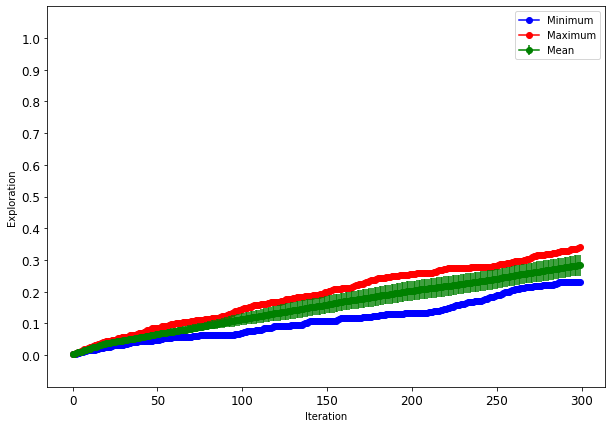

In [10]:
bayesian_benchmark.plot(y_label = 'Exploration', y_min = -0.1, y_max = 1.1)

In [69]:
0.79*3/5

0.47400000000000003

In [43]:
for x in range(20):
    name = 'PSO_' + str(x)
    datalog = pd.read_csv('Data_PSO/' + str(name) + '.txt', sep='\t')
    
    #Reading "Elements" columns from string to list
    datalog['Elements'] = datalog["Elements"].apply(lambda x: literal_eval(x))

    #Creating np.array of "Position" column and dropping the string type "Position" column
    position = []
    for i in range(len(datalog)):
        position.append(list(np.fromstring(datalog['Position'][i][1:-1], dtype=float, sep=' ')))
    position = np.array(position)
    datalog = datalog.drop(columns=['Position'])
    datalog = pd.concat([datalog, pd.DataFrame(([[i] for i in position]), columns = ['Position'])], axis = 1)
    
    #Grid
    PSO_grid = grid(datalog, grid_len = 5, name = name)
    PSO_grid.exploitation_bar_chart(5)
    PSO_grid.exploitation_vs_generation()
    PSO_grid.exploration_vs_generation()

    #Find required generation
    PSO_find_generation = find_generation(datalog, name = name)
    PSO_find_generation.min_value_vs_generation()

In [57]:
PSO_benchmark = benchmark(datatype = 'Exploitation vs Generation Table', 
                               title = 'PSO_',
                               max_generation = 29,
                               repetition = 20,
                               y_value = 'Exploration Value')

In [58]:
PSO_benchmark.table

,Generation,Exploration Value PSO_0,Exploration Value PSO_1,Exploration Value PSO_2,Exploration Value PSO_3,Exploration Value PSO_4,Exploration Value PSO_5,Exploration Value PSO_6,Exploration Value PSO_7,Exploration Value PSO_8,...,Exploration Value PSO_14,Exploration Value PSO_15,Exploration Value PSO_16,Exploration Value PSO_17,Exploration Value PSO_18,Exploration Value PSO_19,Mean,STD,Max,Min
0,0,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,...,0.100,0.100,0.100,0.100,0.100,0.100,0.10000,1.423831e-17,0.100,0.100
1,1,0.100,0.100,0.100,0.100,0.150,0.200,0.100,0.150,0.200,...,0.100,0.100,0.100,0.150,0.200,0.100,0.12750,4.127890e-02,0.200,0.050
2,2,0.200,0.167,0.100,0.200,0.333,0.267,0.167,0.267,0.267,...,0.200,0.133,0.100,0.167,0.300,0.133,0.19675,6.662770e-02,0.333,0.100
3,3,0.300,0.250,0.200,0.350,0.425,0.325,0.275,0.325,0.375,...,0.200,0.225,0.175,0.225,0.325,0.250,0.28750,6.761929e-02,0.425,0.175
4,4,0.320,0.340,0.240,0.360,0.460,0.400,0.340,0.400,0.360,...,0.320,0.280,0.280,0.340,0.300,0.340,0.34000,5.026247e-02,0.460,0.240
5,5,0.400,0.433,0.317,0.450,0.500,0.467,0.367,0.433,0.433,...,0.350,0.367,0.383,0.450,0.367,0.433,0.41005,4.808816e-02,0.500,0.317
6,6,0.400,0.486,0.314,0.500,0.514,0.514,0.414,0.486,0.471,...,0.386,0.443,0.429,0.500,0.400,0.486,0.44930,5.272581e-02,0.514,0.314
7,7,0.450,0.500,0.350,0.550,0.550,0.525,0.475,0.538,0.525,...,0.425,0.500,0.450,0.538,0.462,0.538,0.49260,5.128291e-02,0.550,0.350
8,8,0.500,0.544,0.411,0.589,0.578,0.578,0.511,0.556,0.556,...,0.467,0.533,0.489,0.567,0.500,0.578,0.53060,4.702340e-02,0.589,0.411
9,9,0.520,0.560,0.470,0.630,0.620,0.580,0.530,0.570,0.590,...,0.500,0.550,0.500,0.580,0.530,0.600,0.55750,4.253482e-02,0.630,0.470


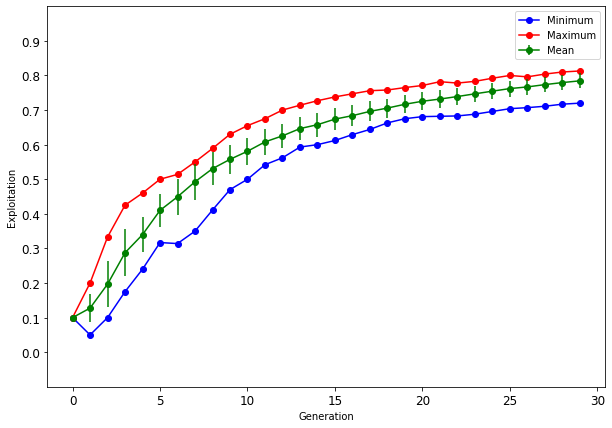

In [60]:
PSO_benchmark.plot(y_label = 'Exploitation', y_min = -0.1, y_max = 1)

In [ ]:
a = np.array([0.464, 0.128, 0.217, 0.042, 0.005, 0.01,  0.042, 0.091])

In [ ]:
np.sqrt(sum((a-bayes_2000_best)**2))